<a href="https://colab.research.google.com/github/danon6868/BI-ml-2024/blob/main/lecture_9_cnn/homework/hw_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
import numpy as np

In [5]:
INPUT_IMAGE_SIZE = 230
BATCH_SIZE = 64
N_EPOCHS = 10 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
print(type(DEVICE))

<class 'str'>


In [9]:
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Compose, ToPILImage
from torchvision.transforms import Normalize, Resize

from glob import glob
from torch import nn
from torch.nn import functional as F
import torch
import os

import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [10]:
class VegetablesDataset(Dataset):
    """
    Этот класс представляет набор данных для обучения нейронной сети, который используется 
    для загрузки изображений овощей.

    Атрибуты:
        img_dir (str): Путь к папке с изображениями овощей.
        side_size (int): Размер стороны изображения по умолчанию.

    Методы:
        __init__(self, img_dir, side_size=INPUT_IMAGE_SIZE):
            Инициализирует набор данных с указанными параметрами.
        
        __len__(self):
            Возвращает общее количество изображений в наборе данных.

        __getitem__(self, idx, normalize=True):
            Возвращает изображение и метку класса по индексу idx.
    """
    def __init__(self, img_dir:str, side_size=INPUT_IMAGE_SIZE):
        """
        Инициализирует набор данных.
        
        Параметры:
            img_dir (str): Путь к папке с изображениями овощей.
            side_size (int): Размер стороны изображения по умолчанию.
        """
        # папка с картинками
        self.img_dir = img_dir
        # отсортированный список с названиями файлов
        self.files = sorted(glob(f'{img_dir}/*/*.jpg'))
        class_names = sorted(os.listdir(img_dir))
        # названия папок с картинками переведем в номера классов
        self.class_dir = {name:idx for idx, name in enumerate(class_names)}
        self._number_to_labels = {idx:name for idx, name in enumerate(class_names)}

        # трансформации данных: мы изменяем размер,
        # так как AlexNet работает с картинками 227 на 227 пикселей
        self.transforms = Compose([ToPILImage(),
                                  Resize(side_size),
                                  ToTensor(),
                                  Normalize(
                                      mean = [0.5183, 0.4845, 0.6570],
                                      std = [0.2111, 0.2227, 0.2291]
                                  )])
        self._transforms_for_plot = Compose([ToPILImage(),
                                  Resize(side_size),
                                  ToTensor()
                                  ])


    def __len__(self):
        """ 
        Считает количество изображений (файлов)
        """
        return len(self.files)

    def __getitem__(self, idx:int, normalize=True):
        """
        Возвращает изображение и метку класса по индексу idx. 
        При этом, если параметр normalize установлен в True,
        то изображение преобразуется с помощью некоторых трансформаций. 
        """
        file_path = self.files[idx]
        image = read_image(file_path).type(torch.DoubleTensor)

        # применяем трансформации
        if normalize:
            transformed_img = self.transforms(image)

        transformed_img = self._transforms_for_plot(image)

        label_name = file_path.split('/')[-2]
        label = self.class_dir[label_name]

        # как обычно возвращаем картинку и номер класса
        return transformed_img, label

In [11]:
train_dataset = VegetablesDataset("./vegetables/train/")
valid_dataset = VegetablesDataset("./vegetables/validation/")
test_dataset = VegetablesDataset("./vegetables/test/")

trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [151]:
N_CLASSES = train_dataset.class_dir.__len__() # определяет число классов в данных
LEARNING_RATE = 3e-4 # можно подобрать другой

In [152]:
class AlexNet(nn.Module):
    """
    Данный класс представляет собой измененение архитектуры нейросети AlexNet. Наследует от базового класса для всех
    модулей нейросетей.
    
    Методы:
        __init__ --- инициализирует свертку объекта согласно модели AlexNet.
        forward --- преобразует изображение согласно архитектуре и вовзвращает вектор и вероятность принадлежности 
        к классу.
    
    """
    def __init__(self, num_classes):    
        """
        Производит свертку изображения, состоит из пяти сверточных слоев, между которыми распологаются пулинг слои
        и слои активации. Завершают нейросеть три линейных слоя. 
        
        На вход принимает изображение в формате тензора, выполняет свертку согласно архитектуре и определяет принадлежность к 
        конкретному классу.
        """
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(9216, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        """
        На вход принимает изображение в формате тензора. Сворачивает согласно AlexNet. Считает вероятность 
        принадлежности к какому-либо классу.
        
        Вовзращает вектор и вероятность принадлежности к конкретному классу.
        """
        x = self.features(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1) 
        return logits, probs

In [153]:
def train_epoch(train_loader:DataLoader, model:nn.Module, criterion:nn.Module, optimizer:torch.optim, device:str):
    """
    Функция для этапа обучения в цикле обучения

    Аргументы:
    train_loader (DataLoader): загрузчик данных для обучения
    model (nn.Module): модель для обучения
    criterion (nn.Module): функция потерь
    optimizer (torch.optim): оптимизатор
    device (str): устройство, на котором происходит обучение (например, 'cpu' или 'cuda')
    
    Возвращает:
    model (nn.Module): обновленная модель
    optimizer (Optimizer): обновленный оптимизатор
    epoch_loss (float): средняя потеря за эпоху
    """
    model.train()
    running_loss = 0

    for X, y_true in train_loader:

        optimizer.zero_grad()

        X = X.to(device)
        y_true = y_true.to(device)

        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)

        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss


def validate_epoch(valid_loader:DataLoader, model:nn.Module, criterion:nn.Module, device:str):
    """
    Функция для этапа валидации в цикле обучения.

    Аргументы:
    valid_loader (DataLoader): загрузчик данных для валидации
    model (nn.Module): модель для валидации
    criterion (nn.Module): функция потерь
    device (str): устройство, на котором происходит валидация (например, 'cpu' или 'cuda')

    Возвращает:
    model (nn.Module): модель после валидации
    epoch_loss (float): средняя потеря за эпоху
    """

    model.eval()
    running_loss = 0

    for X, y_true in valid_loader:

        X = X.to(device)
        y_true = y_true.to(device)

        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)

    return model, epoch_loss


def get_accuracy(model:nn.Module, dataloader:DataLoader, device:str):
    """
    Функция для вычисления accuracy модели на данных.

    Аргументы:
    model (nn.Module): модель для вычисления точности
    dataloader (DataLoader): загрузчик данных для вычисления точности
    device (str): устройство, на котором происходит вычисление точности (например, 'cpu' или 'cuda')
    
    Возвращает:
    accuracy (float): точность модели на данных
    """
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs, _ = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total

    return accuracy


def plot_losses(train_losses:list, valid_losses:list):
    """
    Функция для построения графика потерь на обучающем и валидационном наборах данных

    Аргументы:
    train_losses (list): список значений потерь на обучающем наборе данных
    valid_losses (list): список значений потерь на валидационном наборе данных
    """
    sns.lineplot(x=np.arange(1, len(train_losses)+1), y=train_losses, label="Train Loss")
    sns.lineplot(x=np.arange(1, len(train_losses)+1), y=valid_losses, label="Validation Loss")


def training_loop(model:nn.Module, criterion:nn.Module, optimizer:torch.optim, train_loader:DataLoader, valid_loader:DataLoader, epochs:int, device:str, print_every=1):
    """
    Функция, осуществляющая обучениe модели на заданном количестве эпох.

    Аргументы:
    model (nn.Module): модель для обучения
    criterion (nn.Module): функция потерь
    optimizer (torch.optim): оптимизатор
    train_loader (DataLoader): загрузчик данных для обучения
    valid_loader (DataLoader): загрузчик данных для валидации
    epochs (int): количество эпох обучения
    device (str): устройство, на котором происходит обучение (например, 'cpu' или 'cuda')
    print_every (int): частота вывода информации во время обучения (по умолчанию каждую эпоху)

    Возвращает:
    model (nn.Module): обученная модель
    train_losses (list): список значений потерь на обучающем наборе данных по эпохам
    valid_losses (list): список значений потерь на валидационном наборе данных по эпохам
    """

    best_loss = 1e10
    train_losses = []
    valid_losses = []

    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train_epoch(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate_epoch(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):

            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)

            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)

    return model, train_losses, valid_losses

In [154]:
import torch.nn as nn
import torch.optim as optim

In [155]:
model = AlexNet(N_CLASSES).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion =  nn.CrossEntropyLoss()

22:37:56 --- Epoch: 0	Train loss: 1.8384	Valid loss: 1.8456	Train accuracy: 16.75	Valid accuracy: 16.67
22:39:22 --- Epoch: 1	Train loss: 1.6375	Valid loss: 1.4501	Train accuracy: 36.83	Valid accuracy: 37.50
22:40:50 --- Epoch: 2	Train loss: 1.0806	Valid loss: 0.8287	Train accuracy: 67.54	Valid accuracy: 65.50
22:42:18 --- Epoch: 3	Train loss: 0.6894	Valid loss: 0.5981	Train accuracy: 78.12	Valid accuracy: 76.67
22:43:51 --- Epoch: 4	Train loss: 0.4761	Valid loss: 0.5785	Train accuracy: 77.38	Valid accuracy: 75.67
22:45:24 --- Epoch: 5	Train loss: 0.3736	Valid loss: 0.4855	Train accuracy: 84.46	Valid accuracy: 81.67
22:46:58 --- Epoch: 6	Train loss: 0.3665	Valid loss: 0.2637	Train accuracy: 93.71	Valid accuracy: 90.50
22:48:32 --- Epoch: 7	Train loss: 0.2048	Valid loss: 0.2216	Train accuracy: 96.08	Valid accuracy: 94.17
22:50:09 --- Epoch: 8	Train loss: 0.1723	Valid loss: 0.3051	Train accuracy: 95.21	Valid accuracy: 92.50
22:51:44 --- Epoch: 9	Train loss: 0.1532	Valid loss: 0.3726	Trai

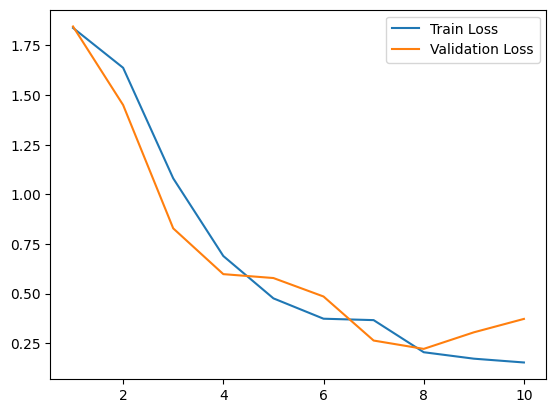

In [156]:
model, train_losses, val_losses = training_loop(model, criterion, optimizer, trainloader, validloader, N_EPOCHS, DEVICE)

При оптимизаторе Adam на 10 эпохах максимальный `accuracy` на валидации получился: 94.17.
При оптимизаторе RMSprop на 10 эпохах максимальный `accuracy` на валидации получился: 48.50.

### Визуализация предсказаний

Визуализируем предсказания нашей модели и степень уверенности в них. Сделайте выводы о качестве полученной модели.

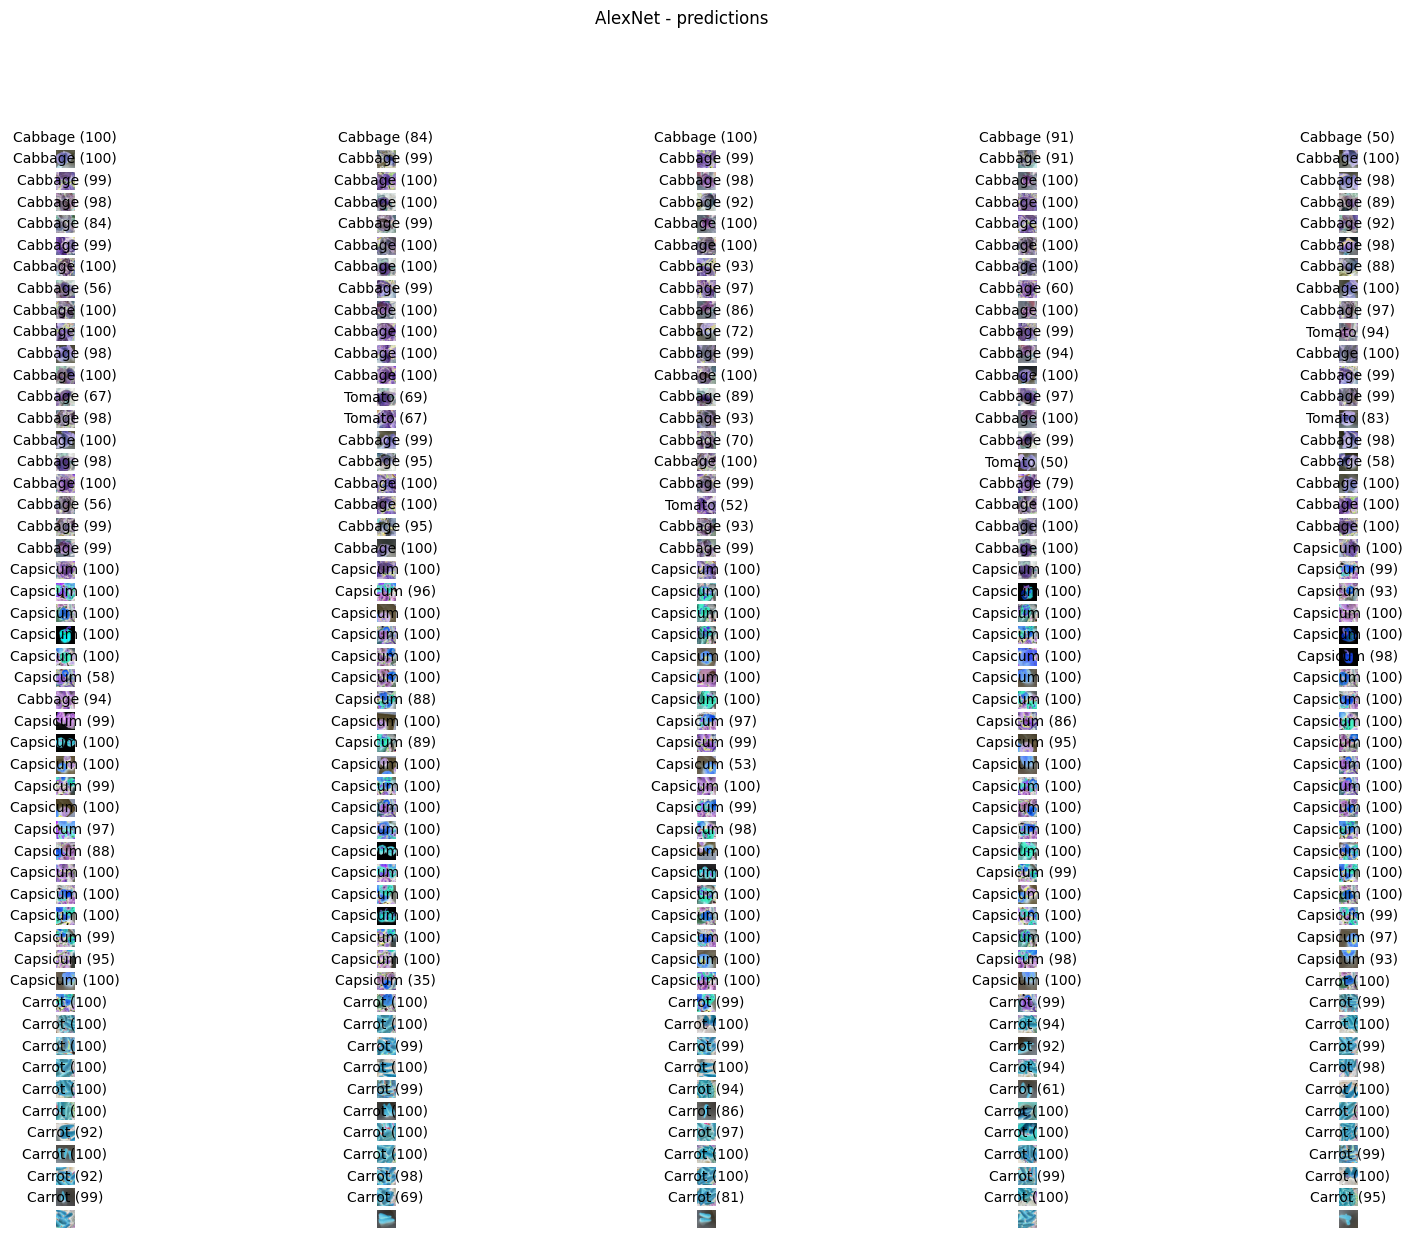

In [28]:
ROW_IMG = 5
N_ROWS = 50

fig = plt.figure(figsize=(20, 14))
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset.__getitem__(index, normalize=False)[0].permute(1, 2, 0))

    with torch.no_grad():
        # error)
        model.cpu().eval()
        _, probs = model(valid_dataset[index][0].unsqueeze(0))

    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    title = f"{valid_dataset._number_to_labels[torch.argmax(probs).item()]} ({torch.max(probs * 100):.0f})"

    plt.title(title, fontsize=10)
fig.suptitle('AlexNet - predictions');